In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
from collections import Counter
from datetime import datetime
from pprint import pprint
import math
import random
import json

### Scan for pnr
#\b\d{12}\b|\d{8}-\w{4}

In [2]:
filePath = "..\\..\\Files\\"

In [3]:
reloadDataFiles = True

# Import files

In [4]:
def LoadDrFile(initials):
    drDfVisists = pd.read_excel(f"{filePath}{initials}_besök.xlsx");
    drDfPhone = pd.read_excel(f"{filePath}{initials}_telefon.xlsx");
    drDfAdmin = pd.read_excel(f"{filePath}{initials}_indirekt.xlsx");
    drDf = drDfVisists.append(drDfPhone, ignore_index=True)
    drDf = drDf.append(drDfAdmin, ignore_index=True)
    limitColsDf = drDf.loc[:, ["Personnr", "Variabelnamn i M4", "Besöksdatum"] ]
    nonNaNDf = limitColsDf.loc[limitColsDf['Personnr'].notnull()]
    nonNaNDf["Initials"] = initials
    return nonNaNDf

In [5]:
if reloadDataFiles:
    JK = LoadDrFile("JK")
    MT = LoadDrFile("MT")
    LW = LoadDrFile("LW")
    MN = LoadDrFile("MN")
    MS = LoadDrFile("MS")
    RA = LoadDrFile("RA")
    QR = LoadDrFile("QR")

C:\ProgramData\Anaconda3\envs\aienv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [6]:
if reloadDataFiles:
    listingOriginalDf = pd.read_excel(f"{filePath}Listing_AFTER_COMPLETION.xlsx")
    listingDf = listingOriginalDf.loc[:, ["Pnr", "Vårdgivare"]]
    listingDf.head(2)

In [7]:
DrToInitials = {
    'ARVIDSSON, RASMUS': "RA",
    'HÄLSOCENTRALEN SANKT HANS, VC': "HC",
    'KOSJERINA, JULIJANA': "JK",
    'NILSSON, MARIA K (ST-LÄKARE)': "MN",
    'ROMERO, QUINCI (ST-LÄKARE)': "QR",
    'SVENSSON, MARIA MC': "MS",
    'TRATTNER, MICHAEL': "MT",
    'WIDÉN, LINN': "LW",
}

In [8]:
if reloadDataFiles:
    listingDf.rename(columns={"Pnr": "Personnr", "Vårdgivare": "Listing"}, inplace=True)
    listingDf["Listing"] = listingDf["Listing"].apply(lambda name: DrToInitials[name] )
    listingDf.head()

In [9]:
if reloadDataFiles:
    listingDict = dict(zip(listingDf["Personnr"], listingDf["Listing"]))

## Lägg ihop alla besök med listad läkar som egen kolumn

In [10]:
if reloadDataFiles:
    allContacts = JK.append(MT, ignore_index=True)
    allContacts = allContacts.append(LW, ignore_index=True)
    allContacts = allContacts.append(MN, ignore_index=True)
    allContacts = allContacts.append(MS, ignore_index=True)
    allContacts = allContacts.append(RA, ignore_index=True)
    allContacts = allContacts.append(QR, ignore_index=True)

In [11]:
if reloadDataFiles:
    allContacts["Personnr"] = allContacts["Personnr"].str.replace(r"(\d{8})(\w{4})", r"\1-\2")

In [12]:
if reloadDataFiles:
    print(set(allContacts["Variabelnamn i M4"]))

{'Telefon', 'Planerade mottagningsbesök', 'Indirekt kontakt', 'Planerat hembesök'}


In [13]:
visitTypeDict = {
    'Indirekt kontakt': "adm",
    'Planerade mottagningsbesök': "visit",
    'Planerat hembesök': "visit",
    'Telefon': "tel"
}

In [14]:
if reloadDataFiles:
    allContacts.rename(columns = {"Variabelnamn i M4" : "VisitType"}, inplace=True)
    allContacts["VisitType"] = allContacts["VisitType"].apply(lambda x: visitTypeDict[x])
    #print(allContacts.head(1))

In [15]:
def checkListing(personnr):
    if not personnr in listingDict:
        return "unknown"
    
    return listingDict[personnr]

In [16]:
if reloadDataFiles:
    allContacts["Listing"] = allContacts["Personnr"].apply( checkListing )

In [17]:
if reloadDataFiles:
    allContacts.to_excel(f"{filePath}allContacts.xlsx")
else:
    allContacts = pd.read_excel(f"{filePath}allContacts.xlsx")
    allContacts.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)

In [18]:
if reloadDataFiles:
    listingDf["Visits (n)"] = listingDf["Personnr"].apply(
        lambda personnr: len(allContacts.loc[ 
            (allContacts["Personnr"] == personnr) & 
            (allContacts["VisitType"] == "visit")].index))

    listingDf["Tel (n)"] = listingDf["Personnr"].apply(
        lambda personnr: len(allContacts.loc[ 
            (allContacts["Personnr"] == personnr) & 
            (allContacts["VisitType"] == "tel")].index))

    listingDf["Adm (n)"] = listingDf["Personnr"].apply(
        lambda personnr: len(allContacts.loc[ 
            (allContacts["Personnr"] == personnr) & 
            (allContacts["VisitType"] == "adm")].index))
    
    listingDf.to_excel(f"{filePath}listingCleaned_AFTER_COMPLETION.xlsx")
else:
    listingDf = pd.read_excel(f"{filePath}listingCleaned_AFTER_COMPLETION.xlsx")
    listingDf.drop(columns=["Unnamed: 0"], inplace=True)

### Lägg till antalet besök per listad pat i listingDf

In [19]:
listingDf.loc[:, ["Listing", "Visits (n)", "Tel (n)", "Adm (n)"]].head(2)

,Listing,Visits (n),Tel (n),Adm (n)
0,HC,0,0,0
1,HC,0,0,0


In [20]:
unlistedDf = listingDf.loc[ listingDf["Listing"] == "HC" ]
print(len(unlistedDf.index))


1589


In [21]:
#allContacts.loc[ allContacts["Personnr"] == "some_nr" ]

## Filtrera bort patienter som redan är listade

In [22]:
unlistedContacts = allContacts.loc[ allContacts["Listing"] == "HC" ]

In [23]:
unlistedContacts.to_excel(f"{filePath}unlistedContacts2.xlsx")

In [24]:
len(set(unlistedContacts.loc[:,"Personnr"]))

2

## Ta fram inaktiva patienter (listad på HC som ej haft besök sista åren)

In [25]:
hasVisitSet = set( allContacts.loc[ allContacts["VisitType"] == "visit" ].loc[ : , "Personnr"] )

In [26]:
print(f"There were {len(allContacts.index)} contacts in total.")
print(f"There were {len(allContacts.loc[ (allContacts['Listing'] == 'HC') ].index)} contacts from unlisted patients.")
unlistedHasContactSet = set( allContacts.loc[ (allContacts["Listing"] == "HC") ].loc[ : , "Personnr"] )
print(f"{len(unlistedHasContactSet)} unlisted patients had som form of contact.")
unlistedHasVisitSet = set( allContacts.loc[ (allContacts["Listing"] == "HC") & (allContacts["VisitType"] == "visit") ].loc[ : , "Personnr"] )
print(f"{len(unlistedHasVisitSet)} unlisted patients had a physical visit.")
unlistedHasTelSet = set( allContacts.loc[ (allContacts["Listing"] == "HC") & (allContacts["VisitType"] == "tel") ].loc[ : , "Personnr"] )
print(f"{len(unlistedHasTelSet)} unlisted patients had a tel appointment.")

There were 29151 contacts in total.
There were 4 contacts from unlisted patients.
2 unlisted patients had som form of contact.
1 unlisted patients had a physical visit.
0 unlisted patients had a tel appointment.


In [27]:
print(f"There are {len(listingDf.loc[ listingDf['Listing'] == 'HC' ].index)} unlisted patients in total")

There are 1589 unlisted patients in total


In [28]:
unlistedNoContactSet = listingDf.loc[ (listingDf["Listing"] == "HC") & ~(listingDf["Personnr"].isin(unlistedHasContactSet)) ]
#print(unlistedNoContactSet[:5])
print(len(unlistedNoContactSet))

1587


In [29]:
unlistedNoContactDf = unlistedDf.loc[ ~(unlistedDf["Personnr"].isin(unlistedHasContactSet)) ]
unlistedNoContactDf = unlistedNoContactDf.copy()
print(len(unlistedNoContactDf.index))
unlistedNoContactDf.loc[: , ["Listing", "Visits (n)", "Tel (n)", "Adm (n)"]].tail(3)

1587


,Listing,Visits (n),Tel (n),Adm (n)
1586,HC,0,0,0
1587,HC,0,0,0
1588,HC,0,0,0


# Beräkningar

#### Använd:
* unlistedContacts - DF med alla olistade patienter som haft besök
* unlistedNoContactDf - DF med patienter som är olistade och inte har haft några kontakter
* unlistedContactsDf - DF med alla kontakter med olistade patienter
* unlistedHasContactSet - set med alla olistade patienter som har en kontakt

### Patient to visits per doctor df

In [30]:
initialsList = ["MT", "JK", "LW", "QR", "MS", "MN", "RA"]
visitTypes = ["visit", "tel", "adm"]

In [31]:
countAndScoreColNames = []
for initials in initialsList:
    for visitType in visitTypes:
        countAndScoreColNames.append(f"{initials}_{visitType}")
        countAndScoreColNames.append(f"{initials}_{visitType}_score")
    countAndScoreColNames.append(f"{initials}_score")
countAndScoreColNames.append(f"total_score")
countAndScoreColNames

['MT_visit',
 'MT_visit_score',
 'MT_tel',
 'MT_tel_score',
 'MT_adm',
 'MT_adm_score',
 'MT_score',
 'JK_visit',
 'JK_visit_score',
 'JK_tel',
 'JK_tel_score',
 'JK_adm',
 'JK_adm_score',
 'JK_score',
 'LW_visit',
 'LW_visit_score',
 'LW_tel',
 'LW_tel_score',
 'LW_adm',
 'LW_adm_score',
 'LW_score',
 'QR_visit',
 'QR_visit_score',
 'QR_tel',
 'QR_tel_score',
 'QR_adm',
 'QR_adm_score',
 'QR_score',
 'MS_visit',
 'MS_visit_score',
 'MS_tel',
 'MS_tel_score',
 'MS_adm',
 'MS_adm_score',
 'MS_score',
 'MN_visit',
 'MN_visit_score',
 'MN_tel',
 'MN_tel_score',
 'MN_adm',
 'MN_adm_score',
 'MN_score',
 'RA_visit',
 'RA_visit_score',
 'RA_tel',
 'RA_tel_score',
 'RA_adm',
 'RA_adm_score',
 'RA_score',
 'total_score']

In [32]:
def countPatientsContactsWithDr(personnr, initials, visitType):
    return len(unlistedContacts.loc[ (unlistedContacts["Personnr"] == personnr) & 
                                   (unlistedContacts["Initials"] == initials) &
                                   (unlistedContacts["VisitType"] == visitType)].index)

#### Vikta besöken efter hur längesen de skedde.

In [33]:
# Weight factor where a visit which happened just now is worth 2 points
# one which happened 1 year ago 1.5 points
# and a bit less than 2 years ago 1 point.

def weightFactorFromDate(dateString):
    date = datetime.strptime(dateString, '%Y-%m-%d')
    originDate = datetime.strptime("2022-04-30", '%Y-%m-%d')
    dateDiff = (originDate - date).days
    return 2 - (dateDiff/650)
    
print(weightFactorFromDate("2022-04-30"))
print(weightFactorFromDate("2021-10-30"))
print(weightFactorFromDate("2021-04-30"))
print(weightFactorFromDate("2020-10-30"))
print(weightFactorFromDate("2020-07-30"))
print(weightFactorFromDate("2020-07-7"))

visitTypeWeightDict = {
    "visit": 1,
    "tel": 0.35,
    "adm": 0.2,
}

2.0
1.72
1.4384615384615385
1.1584615384615384
1.016923076923077
0.9815384615384615


In [34]:
def calculateRowScore(row):
    dateWeightFactor = weightFactorFromDate(row["Besöksdatum"])
    return visitTypeWeightDict[ row["VisitType"] ] * dateWeightFactor

# testRow = unlistedContacts.loc[ list(unlistedContacts.index)[20] , :]
# pprint(testRow.loc[list(set(testRow.index) - set(["Personnr"]))])
# print(f"Score: {calculateRowScore( testRow )}")

In [35]:
unlistedContacts["rowScore"] = unlistedContacts.apply(calculateRowScore, axis=1)

C:\ProgramData\Anaconda3\envs\aienv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
unlistedContacts.loc[:, ["VisitType", "Besöksdatum", "Initials", "Listing", "rowScore"]].head(2)

,VisitType,Besöksdatum,Initials,Listing,rowScore
14770,visit,2021-02-11,LW,HC,1.318462
20492,adm,2021-06-18,MN,HC,0.302769


In [37]:
unlistedContacts.columns

Index(['Personnr', 'VisitType', 'Besöksdatum', 'Initials', 'Listing',
       'rowScore'],
      dtype='object')

In [38]:
def createPatientRowOfVisitsPerDr(personnr):
    patientsIndividualDf = unlistedContacts.loc[ unlistedContacts["Personnr"] == personnr ]
    
    row = {"Personnr": personnr}
    totalScore = 0
    
    for initials in initialsList:
        
        drIndividualDf = patientsIndividualDf.loc[ patientsIndividualDf["Initials"] == initials ]
        
        individualScore = 0
        
        for visitType in visitTypes:
            
            visitTypeDf = drIndividualDf.loc[ drIndividualDf["VisitType"] == visitType ]
            row[f"{initials}_{visitType}"] = len( visitTypeDf.index )
            score = visitTypeDf["rowScore"].sum()
            row[f"{initials}_{visitType}_score"] = score
            individualScore += score
            
        row[f"{initials}_score"] = individualScore
        totalScore += individualScore
    row[f"total_score"] = totalScore
    return row

In [39]:
patientVisitPerDrList = []
limit = -1
i = 0
for personnr in unlistedHasContactSet:
    i += 1
    if limit > 0 and i > limit:
        break
    
    patientVisitPerDrList.append(createPatientRowOfVisitsPerDr(personnr))
    
    
unlistedPatientScoreDf = pd.DataFrame(patientVisitPerDrList, columns=["Personnr"] + countAndScoreColNames)
unlistedPatientScoreDf.loc[:, countAndScoreColNames].head()

,MT_visit,MT_visit_score,MT_tel,MT_tel_score,MT_adm,MT_adm_score,MT_score,JK_visit,JK_visit_score,JK_tel,...,MN_adm_score,MN_score,RA_visit,RA_visit_score,RA_tel,RA_tel_score,RA_adm,RA_adm_score,RA_score,total_score
0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,...,0.302769,0.302769,0,0.0,0,0.0,0,0.0,0.0,0.605538
1,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,...,0.000000,0.000000,0,0.0,0,0.0,0,0.0,0.0,2.643077


In [40]:
def countDrAmountOfPatientsForEachVisitAmount(initials):
    counter = Counter(unlistedPatientScoreDf[f"{initials}_visit"])
    return dict(counter)
    #return sorted(counter.items())

In [41]:
unlistedVisistsPerDrDict = {}
for initials in initialsList:
    unlistedVisistsPerDrDict[initials] = countDrAmountOfPatientsForEachVisitAmount(initials)
    
unlistedVisistsPerDrDict

{'MT': {0: 2},
 'JK': {0: 2},
 'LW': {0: 1, 1: 1},
 'QR': {0: 2},
 'MS': {0: 1, 1: 1},
 'MN': {0: 2},
 'RA': {0: 2}}

In [42]:
unlistedVisistsPerDrList = []
for i in range(6):
    #row = {"Visits (n)": i}
    row = {}
    for initials in initialsList:
        if i in unlistedVisistsPerDrDict[initials]:
            row[initials] = unlistedVisistsPerDrDict[initials][i]
        else:
            row[initials] = 0
    unlistedVisistsPerDrList.append(row)
    
unlistedVisistsPerDrDf = pd.DataFrame(unlistedVisistsPerDrList, columns=initialsList)
unlistedVisistsPerDrDf

,MT,JK,LW,QR,MS,MN,RA
0,2,2,1,2,1,2,2
1,0,0,1,0,1,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0


### Extremt aktiva till JK och MT

Histogram of total score


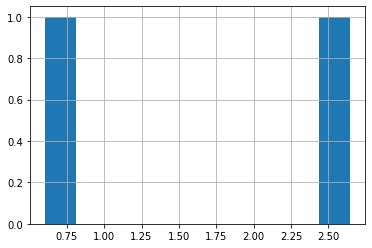

In [43]:
print("Histogram of total score")
unlistedPatientScoreDf.loc[:, "total_score"].hist()

### Most active patients

In [44]:
def ageFromPersonnr(personnrStr):
    match = re.search(r"(\d{4})", personnrStr)
    year = int(match[1])
    return 2022 - year
    
ageFromPersonnr("19870323-abcd")

35

In [45]:
ageAndScoreDf = unlistedPatientScoreDf.loc[:, ["Personnr", "total_score"]].copy()

In [46]:
ageAndScoreDf["age"] = ageAndScoreDf["Personnr"].apply(ageFromPersonnr)

## Age distribution of patients

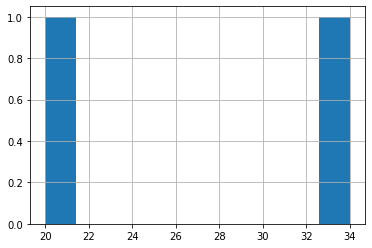

In [47]:
ageAndScoreDf["age"].hist()

### Contact score per age

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


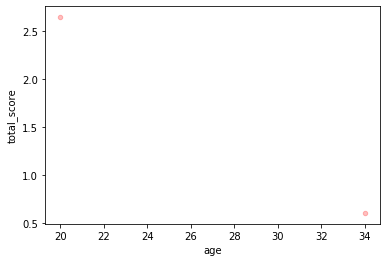

In [48]:
test = np.array([1,0,0,0.25])
test.reshape(1, -1)
ageAndScoreDf.plot.scatter(x="age", y="total_score", c=test )

In [49]:
scoreLimitForHeavy = 5
unlistedHeavySet = set( unlistedPatientScoreDf.loc[ unlistedPatientScoreDf["total_score"] >= scoreLimitForHeavy ].loc[ : ,"Personnr"] )
heavyN = len(unlistedHeavySet)
unlistedN = len(unlistedDf.index)
print(f"Heavy ({heavyN}) / unlisted {unlistedN} = {100 * heavyN / unlistedN} %")

Heavy (0) / unlisted 1589 = 0.0 %


#### Extremely active to JK & MT

In [50]:
def GetExtremelyActiveForDr(initials, scoreLimit, otherAllowedFraction):
    resultDf = unlistedPatientScoreDf.loc[ (unlistedPatientScoreDf[f"{initials}_score"] > scoreLimit) |
                                           (unlistedPatientScoreDf[f"{initials}_visit"] >= 3) ]

    otherInitialsList = ["RA", "QR", "MS", "MN", "LW"]

    for otherInitials in otherInitialsList:
        resultDf = resultDf.loc[ resultDf[f"{otherInitials}_score"] < resultDf[f"{initials}_score"] * otherAllowedFraction ]

    return resultDf.loc[:, [
                 'Personnr',
                 f'{initials}_visit',
                 f'{initials}_visit_score',
                 f'{initials}_tel',
                 f'{initials}_tel_score',
                 f'{initials}_adm',
                 f'{initials}_adm_score',
                 f'{initials}_score',
                 'total_score',]]

In [51]:
extremelyActiveJK = GetExtremelyActiveForDr("JK", 3, 0.4)

In [52]:
extremelyActiveMT = GetExtremelyActiveForDr("MT", 3, 0.4)

### Patients with contacts but no visits?

In [53]:
unlistedContactNoVisitDf = unlistedDf.loc[ (unlistedDf["Visits (n)"] == 0) & ((unlistedDf["Tel (n)"] > 0) | (unlistedDf["Adm (n)"] > 0)) ]
print(len(unlistedContactNoVisitDf))
unlistedContactNoVisitDf.loc[:, ["Listing", "Visits (n)", "Tel (n)", "Adm (n)"]].head()

1


,Listing,Visits (n),Tel (n),Adm (n)
578,HC,0,0,2


## Calculate target amount of listings per dr except for MT and JK

#### First, calculate current amount of listed patients and how many of those are actively seeking care

In [54]:
listingDf.loc[:, ["Listing", "Visits (n)", "Tel (n)", "Adm (n)"]].head(2)

,Listing,Visits (n),Tel (n),Adm (n)
0,HC,0,0,0
1,HC,0,0,0


In [55]:
def getAmountsListedPerDr(minVisits):
    amountListedPerDr = {}
    for initials in initialsList:
        amount = len(listingDf.loc[ (listingDf["Listing"] == initials) &
                                            (listingDf["Visits (n)"] >= minVisits) ].index)
        amountListedPerDr[initials] = amount
        
    return amountListedPerDr
    

In [56]:
print(getAmountsListedPerDr(0))

{'MT': 998, 'JK': 998, 'LW': 998, 'QR': 999, 'MS': 500, 'MN': 510, 'RA': 499}


### For each patient, determine which dr it should go to:
* Never JK or MT
* The one with the highets score.
* Adjusted by a factor for each dr to try to reach the target amount

In [57]:
print(f"Unlisted with som contact {len(unlistedHasContactSet)} and with a visit {len(unlistedHasVisitSet)}");

Unlisted with som contact 2 and with a visit 1


## How many do we have space to list and how many do we need to enlist?

In [58]:
onePlusVisitPatienAmount = len(unlistedDf.loc[ unlistedDf["Visits (n)"] >= 1 ].index)
twoPlusVisitPatienAmount = len(unlistedDf.loc[ unlistedDf["Visits (n)"] >= 2 ].index)
print(f"Totalt antal olistade patienter som sökt 1+ gånger sedan 2021-07: {onePlusVisitPatienAmount}")
print(f"Totalt antal olistade patienter som sökt 2+ gånger sedan 2021-07: {twoPlusVisitPatienAmount}")

Totalt antal olistade patienter som sökt 1+ gånger sedan 2021-07: 1
Totalt antal olistade patienter som sökt 2+ gånger sedan 2021-07: 1


In [59]:
def showListingInfo(initialsToShowList, expectedAmountListedPerDr, total):
    for initials in initialsToShowList:
        value = expectedAmountListedPerDr - tempDict[initials]
        print (f"{initials} har listat {tempDict[initials]}/{expectedAmountListedPerDr}. Återstår att lista: {value}")
        data = {}
        data["currentlyListed"] = tempDict[initials]
        data["expected"] = expectedAmountListedPerDr
        data["slotsLeft"] = value
        openSlotsPerDr[initials] = data
        total["counter"] += value
        total["places"] += expectedAmountListedPerDr

In [60]:
openSlotsPerDr = {}
tempDict = getAmountsListedPerDr(0)
total = {"counter": 0, "places": 0}

showListingInfo(["MS", "MN", "RA"], 500, total)
showListingInfo(["MT", "JK", "LW", "QR"], 1000, total)
    
print(f"Total finns plats att lista {total['counter']} patienter")

MS har listat 500/500. Återstår att lista: 0
MN har listat 510/500. Återstår att lista: -10
RA har listat 499/500. Återstår att lista: 1
MT har listat 998/1000. Återstår att lista: 2
JK har listat 998/1000. Återstår att lista: 2
LW har listat 998/1000. Återstår att lista: 2
QR har listat 999/1000. Återstår att lista: 1
Total finns plats att lista -2 patienter


In [61]:
freeSpaces = total['counter']
expectedTotalListings = total["places"]
totalUnlisted = len(unlistedDf.index)
totalListed = len(listingDf.loc[ listingDf["Listing"] != "HC" ].index)
totalPat = len(listingDf.index)

print(f"""
Totalt antal patienter listade på enheten: {totalPat}
Totalt antal läkar-listade patienter: {totalListed}
Totalt antal läkar-olistade patienter: {totalUnlisted}
Andelen listade: {100*totalListed/totalPat:.0f} %
Antal som behöver listas 75 %: {0.75*totalPat - totalListed:.0f}
Antal som behöver listas 80 %: {0.8*totalPat - totalListed:.0f}
Procent om vi listar {freeSpaces}: {100*(expectedTotalListings)/totalPat:.3f} %""")



Totalt antal patienter listade på enheten: 7091
Totalt antal läkar-listade patienter: 5502
Totalt antal läkar-olistade patienter: 1589
Andelen listade: 78 %
Antal som behöver listas 75 %: -184
Antal som behöver listas 80 %: 171
Procent om vi listar -2: 77.563 %


### Room for active patients:

In [62]:
openSlotsPerDr

{'MS': {'currentlyListed': 500, 'expected': 500, 'slotsLeft': 0},
 'MN': {'currentlyListed': 510, 'expected': 500, 'slotsLeft': -10},
 'RA': {'currentlyListed': 499, 'expected': 500, 'slotsLeft': 1},
 'MT': {'currentlyListed': 998, 'expected': 1000, 'slotsLeft': 2},
 'JK': {'currentlyListed': 998, 'expected': 1000, 'slotsLeft': 2},
 'LW': {'currentlyListed': 998, 'expected': 1000, 'slotsLeft': 2},
 'QR': {'currentlyListed': 999, 'expected': 1000, 'slotsLeft': 1}}

In [63]:
for initials, data in openSlotsPerDr.items():
    print(f"{initials} har nu {data['currentlyListed']} listade (tänkt att ha {data['expected']})")

MS har nu 500 listade (tänkt att ha 500)
MN har nu 510 listade (tänkt att ha 500)
RA har nu 499 listade (tänkt att ha 500)
MT har nu 998 listade (tänkt att ha 1000)
JK har nu 998 listade (tänkt att ha 1000)
LW har nu 998 listade (tänkt att ha 1000)
QR har nu 999 listade (tänkt att ha 1000)


In [64]:
activePatientsToBeListedN = len(unlistedPatientScoreDf.index)
roomForActive = 0

for initials in set(initialsList) - set(["MT", "JK"]):
    slotsLeft = openSlotsPerDr[initials]["slotsLeft"]
    roomForActive += slotsLeft
    
print(f"Room for active patient enlisting: {roomForActive}")
print(f"Amount of active patients: {activePatientsToBeListedN}")
print(f"Amount of nonactive patients to be divided between other than MT and JK:{roomForActive - activePatientsToBeListedN}")
print(f"Per 1000 pat dr:{2 * (roomForActive - activePatientsToBeListedN) / 7:.0f} and per 500 pat dr: {(roomForActive - activePatientsToBeListedN) / 7:.0f}")

Room for active patient enlisting: -6
Amount of active patients: 2
Amount of nonactive patients to be divided between other than MT and JK:-8
Per 1000 pat dr:-2 and per 500 pat dr: -1


In [65]:
stInactiveN = 22
specialistInactiveN = 43

In [66]:
unlistedPatientScoreDf.sort_values(by="total_score", ascending=False, inplace=True)

# Move patients from unlisted to enlisting

In [67]:
def printCurrentStats():
    print(  f"""Unlisted left: {len(totalUnlistedLeftSet)}
Active unlisted left: {len(activeUnlistedLeftDf.index)}
Inactive unlisted left: {len(inactiveUnlistedLeftSet)}
Enlisting: {len(enlistingDf.index)}""")
    for initials in initialsList:
        print(f"Enlisting ({initials}): {len(enlistingDf.loc[ enlistingDf['TargetDr']  == initials ])}")

In [68]:
def removePatientSetFromRemaining(removalSet):
    global activeUnlistedLeftDf, totalUnlistedLeftSet, inactiveUnlistedLeftSet
    totalUnlistedLeftSet -= removalSet
    if removalSet.issubset(inactiveUnlistedLeftSet):
        inactiveUnlistedLeftSet -= removalSet
    if removalSet.issubset(set(activeUnlistedLeftDf.index)):
        activeUnlistedLeftDf = activeUnlistedLeftDf.loc[ set(activeUnlistedLeftDf.index) - removalSet, : ]

In [69]:
# def removePatientFromRemaining(personnrStr):
#     totalUnlistedLeftSet.remove(personnrStr)
#     if personnrStr in inactiveUnlistedLeftSet:
#         inactiveUnlistedLeftSet.remove(personnrStr)
#     if personnrStr in activeUnlistedLeftDf.index:
#         activeUnlistedLeftDf.drop(personnrStr, inplace=True)

In [70]:
def performEnlisting(initials, enlistingSet):
    global enlistingDf
    for personnr in enlistingSet:
        row = scoreDf.loc[personnr, :]
        row["TargetDr"] = initials
        enlistingDf = enlistingDf.append(row)
    removePatientSetFromRemaining(enlistingSet)

# Add random unlisted to each dr

In [109]:
inactiveUnlistedLeftSet = set(unlistedNoContactDf["Personnr"])
print(len(inactiveUnlistedLeftSet))

1587


In [115]:
inactiveUnlistedLeftList = random.sample(inactiveUnlistedLeftSet, len(inactiveUnlistedLeftSet))
print(len(inactiveUnlistedLeftList))

1587


In [111]:
amountsListedOnEachDr = getAmountsListedPerDr(0)
amountsListedOnEachDr

{'MT': 998, 'JK': 998, 'LW': 998, 'QR': 999, 'MS': 500, 'MN': 510, 'RA': 499}

In [113]:
amountToListOnEachDr = {
    
}

for initials in ['MT', 'JK', 'LW', 'QR']:
    amountToListOnEachDr[initials] = 1050 - amountsListedOnEachDr[initials]
    
for initials in ['RA', 'MS', 'MN']:
    amountToListOnEachDr[initials] = 550 - amountsListedOnEachDr[initials]
    
amountToListOnEachDr

{'MT': 52, 'JK': 52, 'LW': 52, 'QR': 51, 'RA': 51, 'MS': 50, 'MN': 40}

In [119]:
patListForEachDr = {
    
}

for initials, amount in amountToListOnEachDr.items():
    patListForEachDr[initials] = inactiveUnlistedLeftList[:amount]
    inactiveUnlistedLeftList = inactiveUnlistedLeftList[amount:len(inactiveUnlistedLeftList)]

In [123]:
with open(f"{filePath}UnlistedPatToDr2.txt", "w+") as file:
    file.write(json.dumps(patListForEachDr, indent=2))

In [138]:
def formatPers(inputList, interval=10):
    startPos = 0 - interval
    endPos = 0
    reachedEnd = False

    strRows = []
    
    while not reachedEnd:
        startPos += interval
        endPos += interval
        
        if endPos > len(inputList):
            endPos = len(inputList)
            reachedEnd = True
            
        if startPos < len(inputList) - 1:
            strRows.append('"' + '", "'.join(inputList[startPos : endPos]) + '",\n')
        
    outputStr = "".join(strRows)
                       
    return outputStr

In [144]:
def getToList(initials):
    toDrList = patListForEachDr[initials]
    print(f"Found {len(toDrList)} patients")
    print(formatPers(toDrList))
    
#getToList("RA")

# Verify no duplicates:

In [131]:
total = []
for initials in initialsList:
    total += patListForEachDr[initials]
    
print(f"Total in list {len(total)} and total unique = {len(set(total))}")

Total in list 348 and total unique = 348


<h1 style="color:red;">OLD STUFF OLD STUFF OLD STUFF OLD STUFF OLD STUFF OLD STUFF OLD STUFF OLD STUFF OLD STUFF</h1>
The below is just copied from the original file for handling listing. Above are calculations for adding more random unlisted to each dr.

## Start with active patients
<img src="https://c8.alamy.com/comp/2FWKCW4/math-formulas-mathematical-formulas-on-green-school-chalkboard-handwritten-scientific-math-equations-theories-or-calculations-vector-background-algebra-and-geometry-education-concept-2FWKCW4.jpg" style="max-height:300px">

In [71]:
scoreDf = unlistedPatientScoreDf.set_index("Personnr")
totalUnlistedLeftSet = set(unlistedDf["Personnr"])
inactiveUnlistedLeftSet = set(unlistedNoContactDf["Personnr"])
activeUnlistedLeftDf = scoreDf.copy().sample(frac=1)
enlistingDf = pd.DataFrame(columns = list(unlistedPatientScoreDf.columns) + ["TargetDr"])
printCurrentStats()

# disable chained assignments
pd.options.mode.chained_assignment = None 

Unlisted left: 1589
Active unlisted left: 2
Inactive unlisted left: 1587
Enlisting: 0
Enlisting (MT): 0
Enlisting (JK): 0
Enlisting (LW): 0
Enlisting (QR): 0
Enlisting (MS): 0
Enlisting (MN): 0
Enlisting (RA): 0


### Move patients designated for JK and MT first

In [72]:
performEnlisting("JK", set(extremelyActiveJK["Personnr"]))
printCurrentStats()

Unlisted left: 1589
Active unlisted left: 2
Inactive unlisted left: 1587
Enlisting: 0
Enlisting (MT): 0
Enlisting (JK): 0
Enlisting (LW): 0
Enlisting (QR): 0
Enlisting (MS): 0
Enlisting (MN): 0
Enlisting (RA): 0


In [73]:
performEnlisting("MT", set(extremelyActiveMT["Personnr"]))
printCurrentStats()

Unlisted left: 1589
Active unlisted left: 2
Inactive unlisted left: 1587
Enlisting: 0
Enlisting (MT): 0
Enlisting (JK): 0
Enlisting (LW): 0
Enlisting (QR): 0
Enlisting (MS): 0
Enlisting (MN): 0
Enlisting (RA): 0


## Then active patients to others

In [74]:
for initials in set(initialsList) - {"MT", "JK"}:
    entry = openSlotsPerDr[initials]
    inactiveN = stInactiveN if entry["expected"] == 500 else specialistInactiveN
    if initials == "MS":
        inactiveN = 0
    entry["targetNewActive"] = entry["slotsLeft"] - inactiveN
    
openSlotsPerDr

{'MS': {'currentlyListed': 500,
  'expected': 500,
  'slotsLeft': 0,
  'targetNewActive': 0},
 'MN': {'currentlyListed': 510,
  'expected': 500,
  'slotsLeft': -10,
  'targetNewActive': -32},
 'RA': {'currentlyListed': 499,
  'expected': 500,
  'slotsLeft': 1,
  'targetNewActive': -21},
 'MT': {'currentlyListed': 998, 'expected': 1000, 'slotsLeft': 2},
 'JK': {'currentlyListed': 998, 'expected': 1000, 'slotsLeft': 2},
 'LW': {'currentlyListed': 998,
  'expected': 1000,
  'slotsLeft': 2,
  'targetNewActive': -41},
 'QR': {'currentlyListed': 999,
  'expected': 1000,
  'slotsLeft': 1,
  'targetNewActive': -42}}

In [75]:
orderToEnlistDrs = pd.DataFrame(columns=["Initials", "TargetNewActive"])

In [76]:
orderToEnlistDrsList = []
for key, entry in openSlotsPerDr.items():
    if key not in ["MT", "JK"]:
        row = {"Initials": key, "TargetNewActive": entry["targetNewActive"]}
        orderToEnlistDrsList.append(row)
    
orderToEnlistDrsDf = pd.DataFrame(orderToEnlistDrsList)
orderToEnlistDrsDf.sort_values("TargetNewActive", inplace=True)
orderToEnlistDrsList = orderToEnlistDrsDf.values.tolist()
orderToEnlistDrsList = [entry[0] for entry in orderToEnlistDrsList]
orderToEnlistDrsList

['QR', 'LW', 'MN', 'RA', 'MS']

In [77]:
def evaluatePatientForDr(personnr, row, initials, factor, priorityOthers, debug):
    maxOtherScore = 0
    maxOtherInitials = "<none>"
    priorityOthers = set(priorityOthers)
    
    for otherInitials in (set(initialsList) - set({initials})):
        otherScore = row[f"{otherInitials}_score"]
        ownScore = row[f"{initials}_score"]
        marginFactor = 0.01
        ownScoreFactored = ownScore + factor
        priorityStr = ""
        priorityStr2 = ""
        
        if otherScore > 0.05 and otherInitials in priorityOthers:
            marginFactor = -0.01
            ownScoreFactored = ownScore + factor / 5
            priorityStr = "PRIORITY: "
            priorityStr2 = "(DESPITE OF PRIORITY) "
        
        if otherScore >= ownScoreFactored + marginFactor:
            if debug:
                print(f"{priorityStr}{otherInitials}_score ({otherScore}) > {initials}_score ({ownScore}) + {factor} ({ownScoreFactored})")
            return False
        
        if otherScore > maxOtherScore:
            maxOtherInitials = otherInitials
            maxOtherScore = otherScore
        
    if debug:
        print (f"Max other score was {priorityStr2}{maxOtherInitials} ({maxOtherScore}) < {initials}_score ({ownScore}) + {factor} ({ownScoreFactored})")
    return True

In [78]:
def calculateEnlistingForDr(initials, amount, priorityOthers, simplifyFactor, debug):
    targetNewActive = amount # openSlotsPerDr[initials]["targetNewActive"]
    activeUnlistedLeftDf.sort_values(by=f"{initials}_score", ascending=False, inplace=True)

    enlistedCounter = 0
    safety = 0
    safetyLimit = 10
    factor = 0
    enlistingSet = set()
    while enlistedCounter < targetNewActive and safety < safetyLimit:
        if debug:
            print("\n\n##############################################")
            print("################ NEW ROUND ###################")
            print("##############################################\n")

        for tpl in activeUnlistedLeftDf.iterrows():
            personnr = tpl[0]
            row = tpl[1]
            doEnlist = evaluatePatientForDr(personnr, row, initials, factor + simplifyFactor, priorityOthers, debug)

            if doEnlist and personnr in enlistingSet:
                if debug:
                    print("Already enlisted")
            elif doEnlist:
                enlistedCounter += 1
                enlistingSet.add(personnr)

            if enlistedCounter >= targetNewActive:
                break

        safety += 1
        factor += 0.2

    if debug:
        print(f"\Selected {len(enlistingSet)} / {targetNewActive} patients for enlisting")
    
    return enlistingSet

In [79]:
class Enlister:
    def __init__(self, initials):
        self.initials = initials
        self.targetActive = openSlotsPerDr[initials]["targetNewActive"]
        self.enlistedSoFar = 0
        self.isDone = False
        self.debug = False
        
    def enlistN(self, n, simplifyFactor):
        amount = n
        if self.enlistedSoFar + n > self.targetActive:
            amount = self.targetActive - self.enlistedSoFar
        
        enlistingSet = calculateEnlistingForDr(self.initials, amount, priorityOthers, simplifyFactor, self.debug)
        
        self.enlistedSoFar += len(enlistingSet)
        if (self.enlistedSoFar >= self.targetActive):
            self.isDone = True
        
        performEnlisting(self.initials, enlistingSet)
        removePatientSetFromRemaining(enlistingSet)
        
        return f"{self.initials}: Enlisted {len(enlistingSet)} => {self.enlistedSoFar} / {self.targetActive}: Done - {self.isDone}\n"
        
    def __str__(self):
        return f"Enlister({self.initials})"
    
    def __repr__(self):
        return f"Enlister({self.initials})"

In [80]:
enlisters = []
for initials in orderToEnlistDrsList:
    enlister = Enlister(initials)
    enlisters.append(enlister)
    
print(enlisters)

[Enlister(QR), Enlister(LW), Enlister(MN), Enlister(RA), Enlister(MS)]


In [81]:
def checkIfAllDone():
    for enlister in enlisters:
        if not enlister.isDone:
            return False
    return True

In [82]:
def getPriorityOthers():
    priorityOthers = set()
    for enlister in enlisters:
        if not enlister.isDone:
            priorityOthers.add(enlister.initials)
            
    return priorityOthers

In [83]:
safety = 0
safetyLimit = 99
remainingLastTime = len(activeUnlistedLeftDf.index)
simplifyFactor = 0

while len(activeUnlistedLeftDf.index) > 30 and not checkIfAllDone() and safety <= safetyLimit:
    safety += 1
    remainingNow = len(activeUnlistedLeftDf.index)
    if (remainingNow == remainingLastTime):
        simplifyFactor += 0.2
    
    remainingLastTime = remainingNow
    
    outStr = f"\nACTIVE LEFT: {len(activeUnlistedLeftDf.index)}, ENLISTED: {len(enlistingDf.index)}\n"
    outStr += f"{getPriorityOthers()}\n"
    
    for enlister in enlisters:
        if not enlister.isDone:
            priorityOthers = getPriorityOthers()
            outStr += enlister.enlistN(20, simplifyFactor)
        
    print(outStr)
        

In [84]:
toLwDf = activeUnlistedLeftDf.copy()
toLwDf.sort_values(by="LW_score", ascending=False, inplace=True)
enlistingSet = set(toLwDf.index)
toLwDf["TargetDr"] = "LW"
print(len(enlistingSet))
#toLwDf.loc[ list(toLwDf.index)[:2], ["LW_score", "total_score"] ]

2


In [85]:
enlistingDf = enlistingDf.append(toLwDf, sort=False)
removePatientSetFromRemaining(enlistingSet)
printCurrentStats()

Unlisted left: 1587
Active unlisted left: 0
Inactive unlisted left: 1587
Enlisting: 2
Enlisting (MT): 0
Enlisting (JK): 0
Enlisting (LW): 2
Enlisting (QR): 0
Enlisting (MS): 0
Enlisting (MN): 0
Enlisting (RA): 0


## Compare how heavy burden each one gets

In [86]:
for initials in initialsList:
    mean = enlistingDf.loc[ enlistingDf["TargetDr"] == initials ]["total_score"].mean()
    print(f"{initials}: {mean}")

MT: nan
JK: nan
LW: 1.6243076923076925
QR: nan
MS: nan
MN: nan
RA: nan


# Add the inactive ones at random

In [87]:
rowTemplate = dict(zip(countAndScoreColNames, [0 for x in countAndScoreColNames]))
rowTemplate["TargetDr"] = ""
rowTemplate["Personnr"] = ""

In [88]:
unlistedNoContactDf = unlistedNoContactDf.sample(frac=1) # Shuffle
unlistedNoContactList = list(unlistedNoContactDf["Personnr"])

In [89]:
for initials in initialsList:
    entry = openSlotsPerDr[initials]
    activeEnlisting = len(enlistingDf.loc[ enlistingDf["TargetDr"] == initials ].index)
    entry["currentlyEnlisting"] = activeEnlisting
    entry["targetInactive"]  = entry["slotsLeft"] - activeEnlisting
    print(f"targetInactive {initials}: {entry['targetInactive']}")


targetInactive MT: 2
targetInactive JK: 2
targetInactive LW: 0
targetInactive QR: 1
targetInactive MS: 0
targetInactive MN: -10
targetInactive RA: 1


In [90]:
def enlistOneInactivePat(initials):
    personnr = unlistedNoContactList.pop()
    row = dict(rowTemplate)
    row["TargetDr"] = initials
    series = pd.Series(row)
    enlistingDf.loc[personnr, :] = series
    return personnr

In [91]:
for initials in initialsList:
    entry = openSlotsPerDr[initials]
    removeSet = set()
    targetInactive = entry["targetInactive"]
    
    for i in range(targetInactive):
        personnr = enlistOneInactivePat(initials)
        removeSet.add(personnr)
        
    removePatientSetFromRemaining(removeSet)
    print(f"{initials}: Enlisted {len(removeSet)}")
                          
#enlistingDf.tail(2)  

MT: Enlisted 2
JK: Enlisted 2
LW: Enlisted 0
QR: Enlisted 1
MS: Enlisted 0
MN: Enlisted 0
RA: Enlisted 1


In [92]:
printCurrentStats()

Unlisted left: 1581
Active unlisted left: 0
Inactive unlisted left: 1581
Enlisting: 8
Enlisting (MT): 2
Enlisting (JK): 2
Enlisting (LW): 2
Enlisting (QR): 1
Enlisting (MS): 0
Enlisting (MN): 0
Enlisting (RA): 1


In [93]:
for initials in initialsList:
    entry = openSlotsPerDr[initials]
    print(f"{initials}: {entry['slotsLeft']}")

MT: 2
JK: 2
LW: 2
QR: 1
MS: 0
MN: -10
RA: 1


## Sorting before export

In [94]:
enlistingDf.sort_values(by="total_score", inplace=True, ascending=False)
enlistingDf.sort_values(by="TargetDr", inplace=True)

In [95]:
outputDf = pd.DataFrame(columns=list(enlistingDf.columns))
for initials in initialsList:
    outputDf = outputDf.append(enlistingDf.loc[ enlistingDf["TargetDr"] == initials ].sort_values(by=f"{initials}_score", ascending=False))

# Exporting

In [96]:
exportColumns = []
for initials in initialsList:
    exportColumns.append(f"{initials}_score")

exportColumns.append("total_score")
exportColumns.append("TargetDr")
exportColumns

['MT_score',
 'JK_score',
 'LW_score',
 'QR_score',
 'MS_score',
 'MN_score',
 'RA_score',
 'total_score',
 'TargetDr']

In [97]:
# outputDf.to_excel(f"{filePath}enlistingDf_allColumns.xlsx")
# outputDf.loc[:, exportColumns].to_excel(f"{filePath}enlistingDf_simplified.xlsx")

# Kuriosa

In [98]:
allContactsCalc = allContacts.copy()
allContactsCalc["rowScore"] = allContactsCalc.apply(calculateRowScore, axis=1)

In [99]:
currentListingDict = dict(zip(list(listingDf["Personnr"]), list(listingDf["Listing"])))

In [100]:
futureListingDict = dict(zip(list(enlistingDf.index), list(enlistingDf["TargetDr"])))

In [101]:
def getTargetListing(personnr):
    if personnr in currentListingDict and currentListingDict[personnr] != "HC":
        return currentListingDict[personnr]
    elif personnr in futureListingDict:
        return futureListingDict[personnr]
    else:
        return "<unknown>"

In [102]:
allContactsCalc["TargetListing"] = allContactsCalc["Personnr"].apply(getTargetListing)

In [103]:
Counter(allContactsCalc["TargetListing"])

Counter({'JK': 5183,
         '<unknown>': 9428,
         'MT': 2217,
         'QR': 3049,
         'LW': 3709,
         'MN': 2009,
         'MS': 1786,
         'RA': 1770})

In [104]:
listingDf.columns

Index(['Personnr', 'Listing', 'Visits (n)', 'Tel (n)', 'Adm (n)'], dtype='object')

In [145]:
def getTotalAmountOfListed(initials):
    fromEnlisting = set(enlistingDf.loc[ enlistingDf["TargetDr"] == initials ].index)
    fromListing = set( listingDf.loc[ listingDf["Listing"] == initials ]["Personnr"] )
#     print(f"fromContacts: {len(fromEnlisting)}, eg. {list(fromEnlisting)[:3]}")
#     print(f"fromListing: {len(fromListing)}, eg. {list(fromListing)[:3]}")
    return len(fromEnlisting.union(fromListing))
    
getTotalAmountOfListed("JK")

1000

In [146]:
calc = []
for initials in initialsList:
    
    initials = initials
    listedPats = getTotalAmountOfListed(initials)
    listedContactsAnyDr = len(allContactsCalc.loc[ (allContactsCalc["Listing"] == initials) ].index)
    listedVisitsAnyDr = len(allContactsCalc.loc[ (allContactsCalc["Listing"] == initials) & (allContactsCalc["VisitType"] == "visit") ].index)
    listedScoreAnyDr = allContactsCalc.loc[ (allContactsCalc["Listing"] == initials) ]["rowScore"].sum()
    actualVisits = len(allContactsCalc.loc[ (allContactsCalc["Initials"] == initials) & (allContactsCalc["VisitType"] == "visit") ].index)
    actualContacts = len(allContactsCalc.loc[ (allContactsCalc["Initials"] == initials) ].index)
    actualContactScore = allContactsCalc.loc[ (allContactsCalc["Initials"] == initials) ]["rowScore"].sum()
    scorePerListedVisit = listedScoreAnyDr / listedVisitsAnyDr
    actualVisitScorePerListedPat = actualContactScore / listedPats
    scorePerActualVisit = actualContactScore / actualVisits
    
    row = {
        "initials": initials,
        "listedPats": listedPats,
        "listedContactsAnyDr": listedContactsAnyDr,
        "listedVisitsAnyDr": listedVisitsAnyDr,
        "listedScoreAnyDr": listedScoreAnyDr,
        "actualVisits": actualVisits,
        "actualContacts": actualContacts,
        "actualContactScore": actualContactScore,
        "scorePerListedVisit": scorePerListedVisit,
        "actualVisitScorePerListedPat": actualVisitScorePerListedPat,
        "scorePerActualVisit": scorePerActualVisit,
    }
    calc.append(row)
    
calculationsDf = pd.DataFrame(calc, columns = ["initials", "listedPats", "listedContactsAnyDr", "listedVisitsAnyDr", "listedScoreAnyDr", "actualVisits", "actualContacts", "actualContactScore", "scorePerListedVisit", "actualVisitScorePerListedPat", "scorePerActualVisit"])
#calculationsDf

In [107]:
calculationsDf.to_excel(f"{filePath}calculations2.xlsx")

# More random inactive

In [ ]:
unlisted